# Imports/Functions

In [ ]:
from triples_sampling_utils import *

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fileinput
import os
import shutil
import math
import random as random
from scipy.stats import loguniform
import scienceplots
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import newton

random.seed(1)  # set random seed for consistent sampling
pd.set_option('display.max_columns', None)

# os.environ["PATH"] = "/Library/TeX/texbin:" + os.environ["PATH"]
data_PATH = "./Data/"

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use(["science","notebook"]) 
plt.rc('font', family='serif')

plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)  # Set x-axis tick label size
plt.rc('ytick', labelsize=20)  # Set y-axis tick label size


# read in stellar population with Kroupa IMF

In [4]:
singles_i = pd.read_csv("./Data/kroupa_population_initial.csv") 
singles = pd.read_csv("./Data/kroupa_population_final.csv")

m1s_constantSFR_i = singles_i.query("kstar_1<=1 and mass_1>=0.1")['mass_1'] # initial kroupa masses
m1s_constantSFR  = singles.query("kstar_1<=1 and mass_1>=0.1")['mass_1'] # those still on the MS after 10 Gyr of constant star formation


## From single Kroupa IMF, get triple mass
- assumes simple mass ratios

### initial (`_i`)

In [5]:
mass_triplefraction = [[0.10574792264157319, 2.1526418786692574],
                        [0.21624767972643996, 3.718199608610547],
                        [0.42762979914903076, 6.457925636007801],
                        [0.9778928306368192, 11.937377690802336],
                        [1.1435428088501094, 13.894324853228952],
                        [1.9775000577578266, 25.24461839530332],
                        [3.9105064784322034, 36.00782778864969],
                        [6.394774621219934, 45.20547945205479],
                        [11.693948181473157, 56.947162426614476],
                        [29.242831207597824, 67.90606653620351]]
# Extract masses and triple fractions
masses_trip = [item[0] for item in mass_triplefraction]
triple_fractions = [item[1] for item in mass_triplefraction]


mass_multiplefraction =   [[0.11622294, 0.00313641*100],
                            [0.15393248, 0.00836102*100],
                            [0.20387722, 0.01684225*100],
                            [0.27002695, 0.03184672*100],
                            [0.35763955, 0.05085594*100],
                            [0.47367882, 0.07607926*100],
                            [0.62736805, 0.10397445*100],
                            [0.83092308, 0.11769751*100],
                            [1.10052331, 0.13951625*100],
                            [1.45759769, 0.15402938*100],
                            [1.93052796, 0.15998134*100],
                            [3.9105064784322034, 81.01761252446184],
                            [6.394774621219934, 89.04109589041096],
                            [11.5639657341197, 92.95499021526419],
                            [29.242831207597824, 95.89041095890411]]

masses_bin = [item[0] for item in mass_multiplefraction]
binary_fractions = [item[1] for item in mass_multiplefraction]

# Create an interpolation function
def get_triple_fraction(mass):
    interpolation_function = interp1d(masses_trip, triple_fractions, kind='linear', fill_value="extrapolate")
    return interpolation_function(mass)/100

def get_binary_fraction(mass):
    interpolation_function = interp1d(masses_bin, binary_fractions, kind='linear', fill_value="extrapolate")
    return interpolation_function(mass)/100

In [6]:
import numpy as np
from scipy.interpolate import interp1d

# Assumed inputs: m1s_constantSFR_i, masses_trip, triple_fractions, get_binary_fraction
# Define the triple fraction interpolation function
def get_triple_fraction(mass):
    interpolation_function = interp1d(masses_trip, triple_fractions, kind='linear', fill_value="extrapolate")
    return interpolation_function(mass) / 100

# Example print of total initial stars
print(f"N total Initial = {len(m1s_constantSFR_i)}")

# STEP 1: Assign binaries based on binary fraction
binary_probs = np.vectorize(get_binary_fraction)(m1s_constantSFR_i)
binary_mask = np.random.rand(len(m1s_constantSFR_i)) < binary_probs
m1s_binaries_i = m1s_constantSFR_i[binary_mask]
print(f"N binaries Initial = {len(m1s_binaries_i)}")

# STEP 2: Draw mass ratios and compute secondaries
q = np.random.uniform(0.1, 1.0, size=len(m1s_binaries_i))
m2s_binaries_i = q * m1s_binaries_i
m12s_binaries_i = m1s_binaries_i + m2s_binaries_i

# STEP 3: Assign triples *only after* identifying binaries
triple_probs = np.vectorize(get_triple_fraction)(m1s_binaries_i)
triple_mask = np.random.rand(len(m1s_binaries_i)) < triple_probs

# Extract triple systems
m1s_triples_i = m1s_binaries_i[triple_mask]
print(f"N triples Initial = {len(m1s_triples_i)}")



# Optional: print stats about the primary mass distribution
print(f"Primary mass range in triples: {m1s_triples_i.min():.2f} - {m1s_triples_i.max():.2f}")
print(f"Median primary mass in triples: {np.median(m1s_triples_i):.2f}")


N total Initial = 371001
N binaries Initial = 26806
N triples Initial = 5798
Primary mass range in triples: 0.10 - 147.95
Median primary mass in triples: 4.15


### final (after 10 Gyr constant SFR)

In [7]:
# Example print of total initial stars
print(f"N total Initial = {len(m1s_constantSFR)}")

# STEP 1: Assign binaries based on binary fraction
binary_probs = np.vectorize(get_binary_fraction)(m1s_constantSFR)
binary_mask = np.random.rand(len(m1s_constantSFR)) < binary_probs
m1s_binaries = m1s_constantSFR[binary_mask]
print(f"N binaries Initial = {len(m1s_binaries)}")

# STEP 2: Draw mass ratios and compute secondaries
q = np.random.uniform(0.1, 1.0, size=len(m1s_binaries))
m2s_binaries = q * m1s_binaries
m12s_binaries = m1s_binaries + m2s_binaries

# STEP 3: Assign triples *only after* identifying binaries
triple_probs = np.vectorize(get_triple_fraction)(m1s_binaries)
triple_mask = np.random.rand(len(m1s_binaries)) < triple_probs

# Extract triple systems
m1s_triples = m1s_binaries[triple_mask]
print(f"N triples Initial = {len(m1s_triples)}")


# STEP 5: Compute primary mass in the triple (most massive of the three)
m1s_triples = np.maximum.reduce([m1s_triples])

# Optional: print stats about the primary mass distribution
print(f"Primary mass range in triples: {m1s_triples.min():.2f} - {m1s_triples.max():.2f}")
print(f"Median primary mass in triples: {np.median(m1s_triples):.2f}")


N total Initial = 342458
N binaries Initial = 15040
N triples Initial = 1218
Primary mass range in triples: 0.11 - 11.70
Median primary mass in triples: 0.67


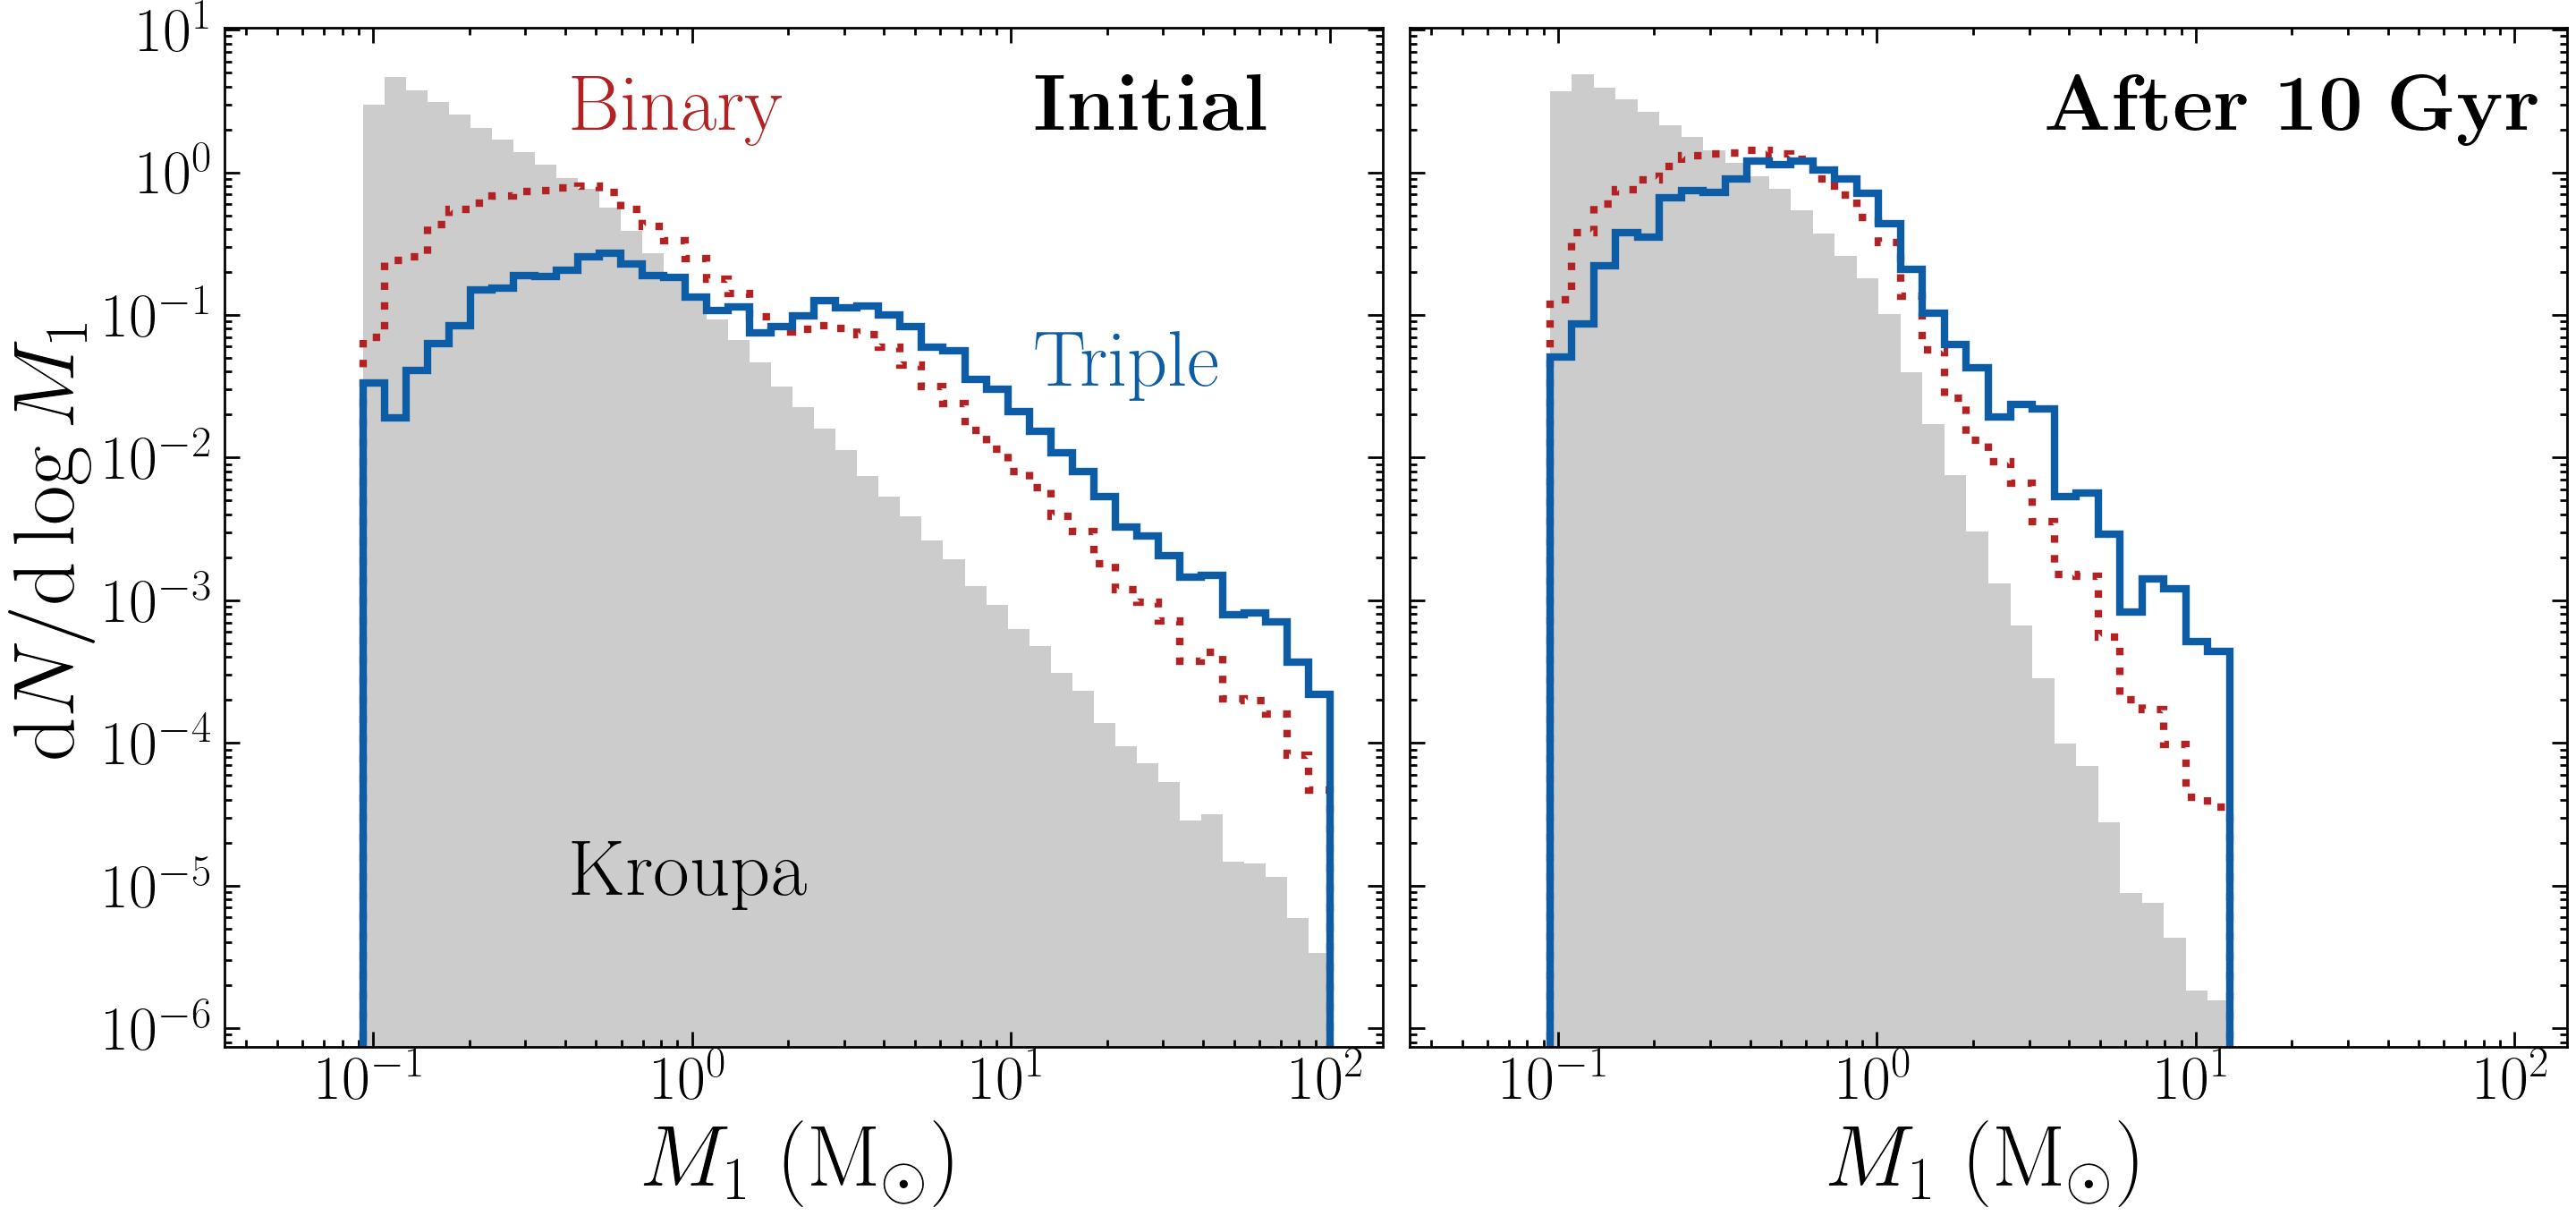

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7),sharey=True)

# First plot
bins = np.logspace(np.log10(0.05), np.log10(100.), 50)
axes[0].hist(m1s_constantSFR_i, bins=bins, density=True, histtype='stepfilled', color='k', linewidth=3, label='', alpha=0.2)
axes[0].hist(m1s_binaries_i, bins=bins, density=True, histtype='step', color='firebrick', linewidth=3, label='Binary', linestyle=':')
axes[0].hist(m1s_triples_i, bins=bins, density=True, histtype='step', color='C0', linewidth=3, label='Triple')

axes[0].set_xlabel(r"$M_1~{\rm (M_\odot)}$", fontsize=35)
axes[0].set_ylabel(r"${\rm d}N/{\rm d}\log M_1$", fontsize=35)
axes[0].text(0.3, 0.15, "Kroupa", transform=axes[0].transAxes, fontsize=32, color='k')
axes[0].text(0.3, 0.9, "Binary", transform=axes[0].transAxes, fontsize=32, color='firebrick')
axes[0].text(0.7, 0.65, "Triple", transform=axes[0].transAxes, fontsize=32, color='C0')
axes[0].text(0.7, 0.9, r"${\bf Initial}$", transform=axes[0].transAxes, fontsize=32, color='k')
axes[0].tick_params(axis='both', labelsize=25)
axes[0].loglog()

# Second plot
bins = np.logspace(np.log10(0.05), np.log10(100.), 49)
axes[1].hist(m1s_constantSFR, bins=bins, density=True, histtype='stepfilled', color='k', linewidth=3, label='', alpha=0.2)
axes[1].hist(m1s_binaries, bins=bins, density=True, histtype='step', color='firebrick', linewidth=3, label='Binary', linestyle=':')
axes[1].hist(m1s_triples, bins=bins, density=True, histtype='step', color='C0', linewidth=3, label='Triple')

axes[1].set_xlabel(r"$M_1~{\rm (M_\odot)}$", fontsize=35)
axes[1].text(0.55, 0.9, r"${\bf After~10~Gyr}$", transform=axes[1].transAxes, fontsize=32, color='k')
axes[1].tick_params(axis='both', labelsize=25)
axes[1].loglog()

plt.tight_layout()
plt.show()


(array([ 0.,  4., 25., 51., 62., 79., 92., 93., 97., 94., 81., 83., 62.,
        53., 69., 45., 29., 27., 25., 13., 12.,  8., 10.,  5., 12.,  7.,
         2.,  3.,  6.,  2.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        , 1.06666667, 1.13333333, 1.2       , 1.26666667,
        1.33333333, 1.4       , 1.46666667, 1.53333333, 1.6       ,
        1.66666667, 1.73333333, 1.8       , 1.86666667, 1.93333333,
        2.        ]),
 <BarContainer object of 30 artists>)

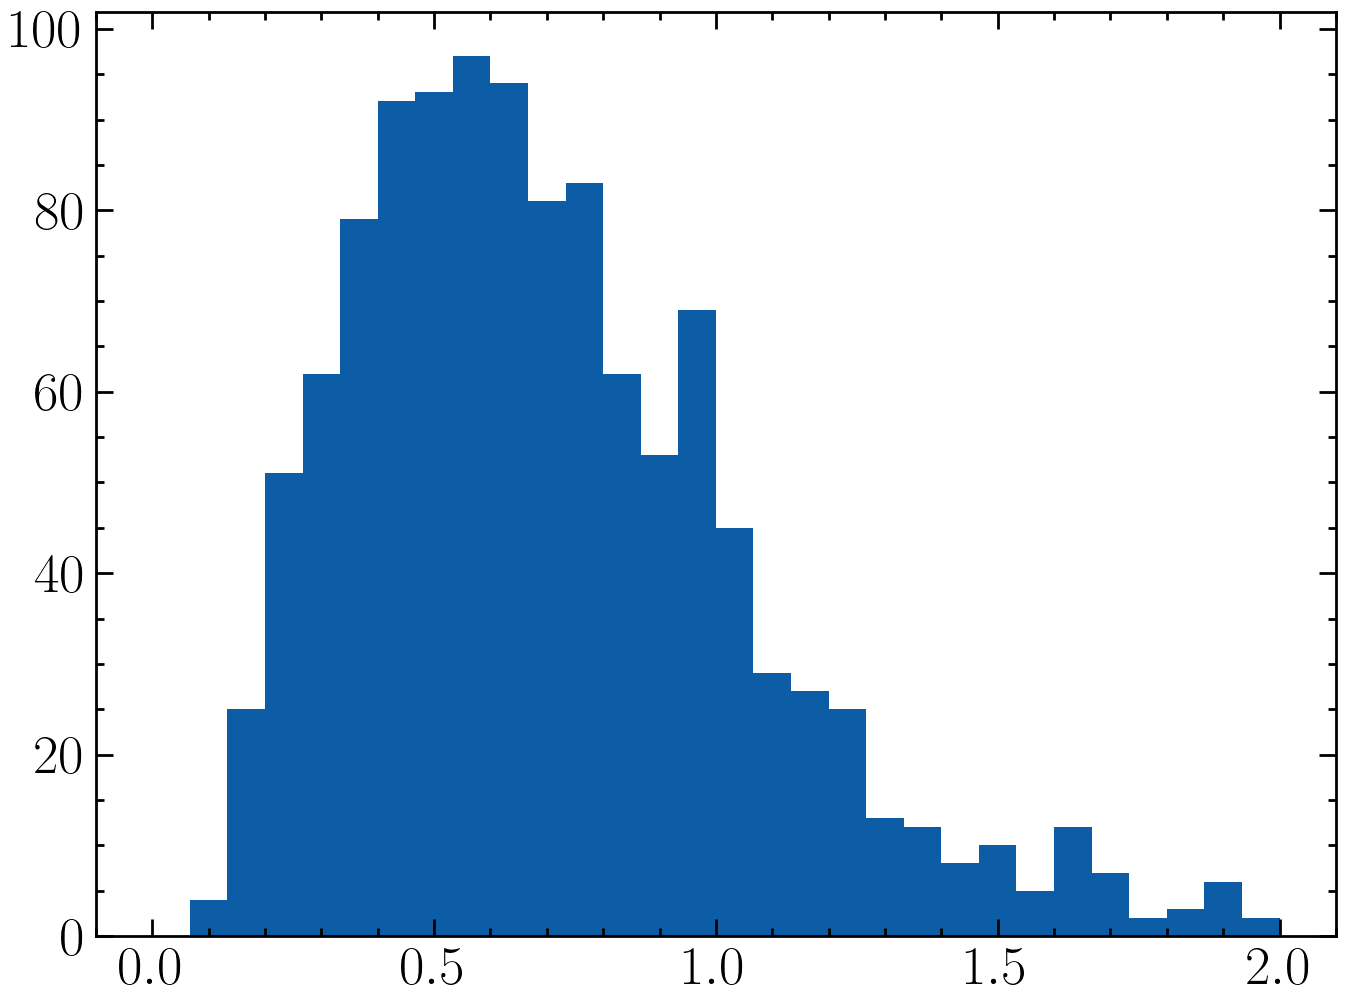

In [24]:
plt.hist(m1s_triples,range=(0,2),bins=30)

# Main Function

In [10]:
def initial_conditions(IMF : str = 'constant_SFR', 
                       Periods : str = 'DM91', 
                       mass_ratios : str = 'default'
                       ): 
    """Sample triple parameters

    Args:
        IMF (str, optional): Initial mass Function for the primary (M1). 
        Periods (str, optional): initial Period Distribution. 
        mass_ratios (str, optional): Mass Ratio Distribution for q_in and q_out.

    Returns:
        _type_: _description_
    """
    
    if IMF == 'Kroupa': 
        m1 = np.random.choice(m1s_triples_i[m1s_triples_i < 2.2]) #random.choices(bins_Kroupa1[:-1], cum_weights = n_Kroupa1)[0]
    elif IMF == 'constant_SFR':
        m1= np.random.choice(m1s_triples)

    if mass_ratios == 'default':
        m2 = m3 = 0
        while m2<0.08 or m3<0.08:
            

            if m1<0.6:
                q_in  = uniform_twin() 
            elif 0.6 <= m1 <1.2:
                popt = (6.02879393,  1.44315185, -1.44329062, 10.,          0.37202403,  0.79529684) 
                q_in = sample_from_doublebroken(1, *popt)[0]
            elif 1.2<=m1 < 2.5:
                popt = (3.60050256,  0.47014287, -2.00243637,  3.1597268,   0.275,       0.59633279) 
                q_in = sample_from_doublebroken(1, *popt)[0]
            elif m1 >= 2.5:
                popt = (3.60050256,  0.0, -1.5,  -1.5,   0.3,       1) 
                q_in = sample_from_doublebroken(1, *popt)[0]
            
            m2 =  m1*q_in

            q_out = return_samples(N = 1, which = 2)[0]# np.random.uniform(0.01,1,1)[0] 
            m3 = q_out * (m1+m2) # np.random.choice(m1s_constantSFR) 
    
    
    R1 = 1.01 * m1**(0.8) 
    R2 = 1.01 * m2**(0.8)
    
    beta = np.random.uniform(0,180)
    beta2 = np.random.uniform(0,180)
    
    gamma = 45.
    gamma2 = 45.
    
    g1 = np.random.uniform(0,360)
    g2 = np.random.uniform(0,360)
    
    age = np.random.uniform(0,10e3) #5e3 #*1.e6, 

    if Periods == 'DM91':
        mu,sigma = 4.8, 2.3 
        P_in,P_out = 10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma) #periods in days #10**np.random.normal(4.8,2.3)
        P_in,P_out = P_in/365.25, P_out/365.25#P_in/365.25, 1876 #periods in yr
    if Periods == 'Raghavan+10':
        mu,sigma = 5.03, 2.28 
        P_in,P_out = 10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma) #periods in days 
        P_in,P_out = P_in/365.25, P_out/365.25#P_in/365.25, 1876 #periods in yr

    if Periods == 'Fischer92': # see also Duchene and Kraus 2013, El-Badry used this in magnetic braking saturates
        mu,sigma = 3.75, 1.3 
        P_in,P_out = 10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma) #periods in days #10**np.random.normal(4.8,2.3)
        P_in,P_out = P_in/365.25, P_out/365.25#P_in/365.25, 1876 #periods in yr

    if Periods == 'combined_log_normal':
        if m1 < 0.5:
            mu,sigma = 4.1, 1.3 # if low mass primary, use Fischer (more close binaries)
        else:
             mu,sigma = 4.8, 2.3 # if at elsat K-dward priary, use DM91
        P_in,P_out = 10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma) #periods in days #10**np.random.normal(4.8,2.3)
        P_in,P_out = P_in/365.25, P_out/365.25#P_in/365.25, 1876 #periods in yr
    if Periods == 'Sana+12_days':
        sample1, sample2 = 10**return_samples(N = 1, which = 3)[0]/365.25, 10**return_samples(N = 1, which = 3)[0]/365.25  
        P_in,P_out = np.minimum(sample1, sample2), np.maximum(sample1, sample2)
    if Periods == 'log_uniform':
        periods = sample_log_uniform(x1 = 100, x2=1e7, size=2) #log-uniform in this range in DAYS
        P_in, P_out = np.min(periods)/365.25, np.max(periods)/365.25 #days to year
        
    if Periods == 'eb18':
        alpha = -1.6
        xmin = 50
        xmax = 50000
        seps_sampled = sample_power_law(alpha, xmin, xmax, size=(1, 2))
        a1 = np.min(seps_sampled, axis=1)[0]
        a2 = np.max(seps_sampled, axis=1)[0]
    elif Periods == 'LU':
        seps_sampled = sample_log_uniform(x1 = 10, x2=100000, size=2)
        a1 = np.min(seps_sampled)
        a2 = np.max(seps_sampled)
    
    else:
        a1,a2 = Kepler_3rdLaw(P_in,m1,m2), Kepler_3rdLaw(P_out,m1+m2,m3) 

    ecc = 'uniform'
    sigma_e = 0.3
    
    if ecc == 'thermal':
        e1  = sample_thermal_eccentricity(n_samples = 1)[0]
        e2  = sample_thermal_eccentricity(n_samples = 1)[0]
    elif ecc == 'uniform':
        e1  = np.random.uniform(0,1)
        e2  = np.random.uniform(0,1)
    elif ecc =='Rayleigh':
        e1 = np.random.rayleigh(scale=sigma_e)
        e2 = np.random.uniform(0,1)

    #inclination
    cosi = np.random.uniform(np.cos(0),np.cos(np.pi))
    i = np.rad2deg(np.arccos(cosi))

    t_i = 0.0
    # check if stable
    criteria = get_all_criteria(a1,a2,e1,e2,m1=m1,m2=m2,m3=m3,R1=R1,R2=R2,i=i,q_out=q_out)
    
    if criteria:
        return np.array([m1,m2,m3,R1,R2,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,t_i,age])
    else:
        return initial_conditions(IMF = IMF, Periods = Periods, mass_ratios = mass_ratios)
        

# Example Sampling 

### Generates a triple population, indicates which would be resolved by Gaia

In [34]:
def sample_all(this_IMF = 'constant_SFR', this_Periods = 'DM91', this_IMRD='default'):
    m1s,m2s,m3s,a1s,a2s,e1s,e2s = [],[],[],[],[], [], []

    for _ in range(10000):
        m1,m2,m3,R1,R2,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,t_i,age = initial_conditions(IMF = this_IMF, Periods = this_Periods, mass_ratios=this_IMRD)
        m1s.append(m1),m2s.append(m2),m3s.append(m3)
        a1s.append(a1),a2s.append(a2)
        e1s.append(e1),e2s.append(e2)

    m1s,m2s,m3s,a1s,a2s,e1s,e2s =  np.array(m1s).astype(float), np.array(m2s).astype(float), np.array(m3s).astype(float), np.array(a1s).astype(float), np.array(a2s).astype(float), np.array(e1s).astype(float), np.array(e2s).astype(float)

    s1s, s2s = compute_projected_separations(a1 = a1s, a2 = a2s, e1 = e1s, e2 = e2s, num_samples = 1)

    # Create the DataFrame
    results_df = pd.DataFrame({
        'ID': list(range(len(m1s))),
        'm1': m1s,
        'm2': m2s,
        'm3': m3s,
        'a1': s1s,
        'a2': s2s,
        's1': s1s,
        's2': s2s,
        'e2': e2s,
    })

    results_df['sep1_AU'] = results_df['s1']
    results_df['sep2_AU'] = results_df['s2']
    results_df = add_resolved_new(results_df, num_iterations=1)

    return results_df

# log-normal for solar-type and for low-mass stars (different for both)
results_df_dm91comb = sample_all(this_IMF = 'constant_SFR', this_Periods = 'DM91', this_IMRD='default')

# log-normal for solar-type and for low-mass stars (different for both)
# results_df_dm91comb = sample_all(this_IMF = 'constant_SFR', this_Periods = 'combined_log_normal', this_IMRD='default')

# results_df_ragh10 = sample_all(this_IMF = 'constant_SFR', this_Periods = 'Raghavan+10', this_IMRD='default')


### Apply Gaia selection function
1. Convert Masses to absolute magnitudes (Mg)
2. Sample distances from observed triples to convert Mg to G (apparent magntiude)
3. Apply Contrast ratio limit (angular separation)

All applied in `add_resolved_new()` function

In [35]:
# Fully resolved triples
results_resolved = results_df_dm91comb.query("resolved_sep == 'Y'")

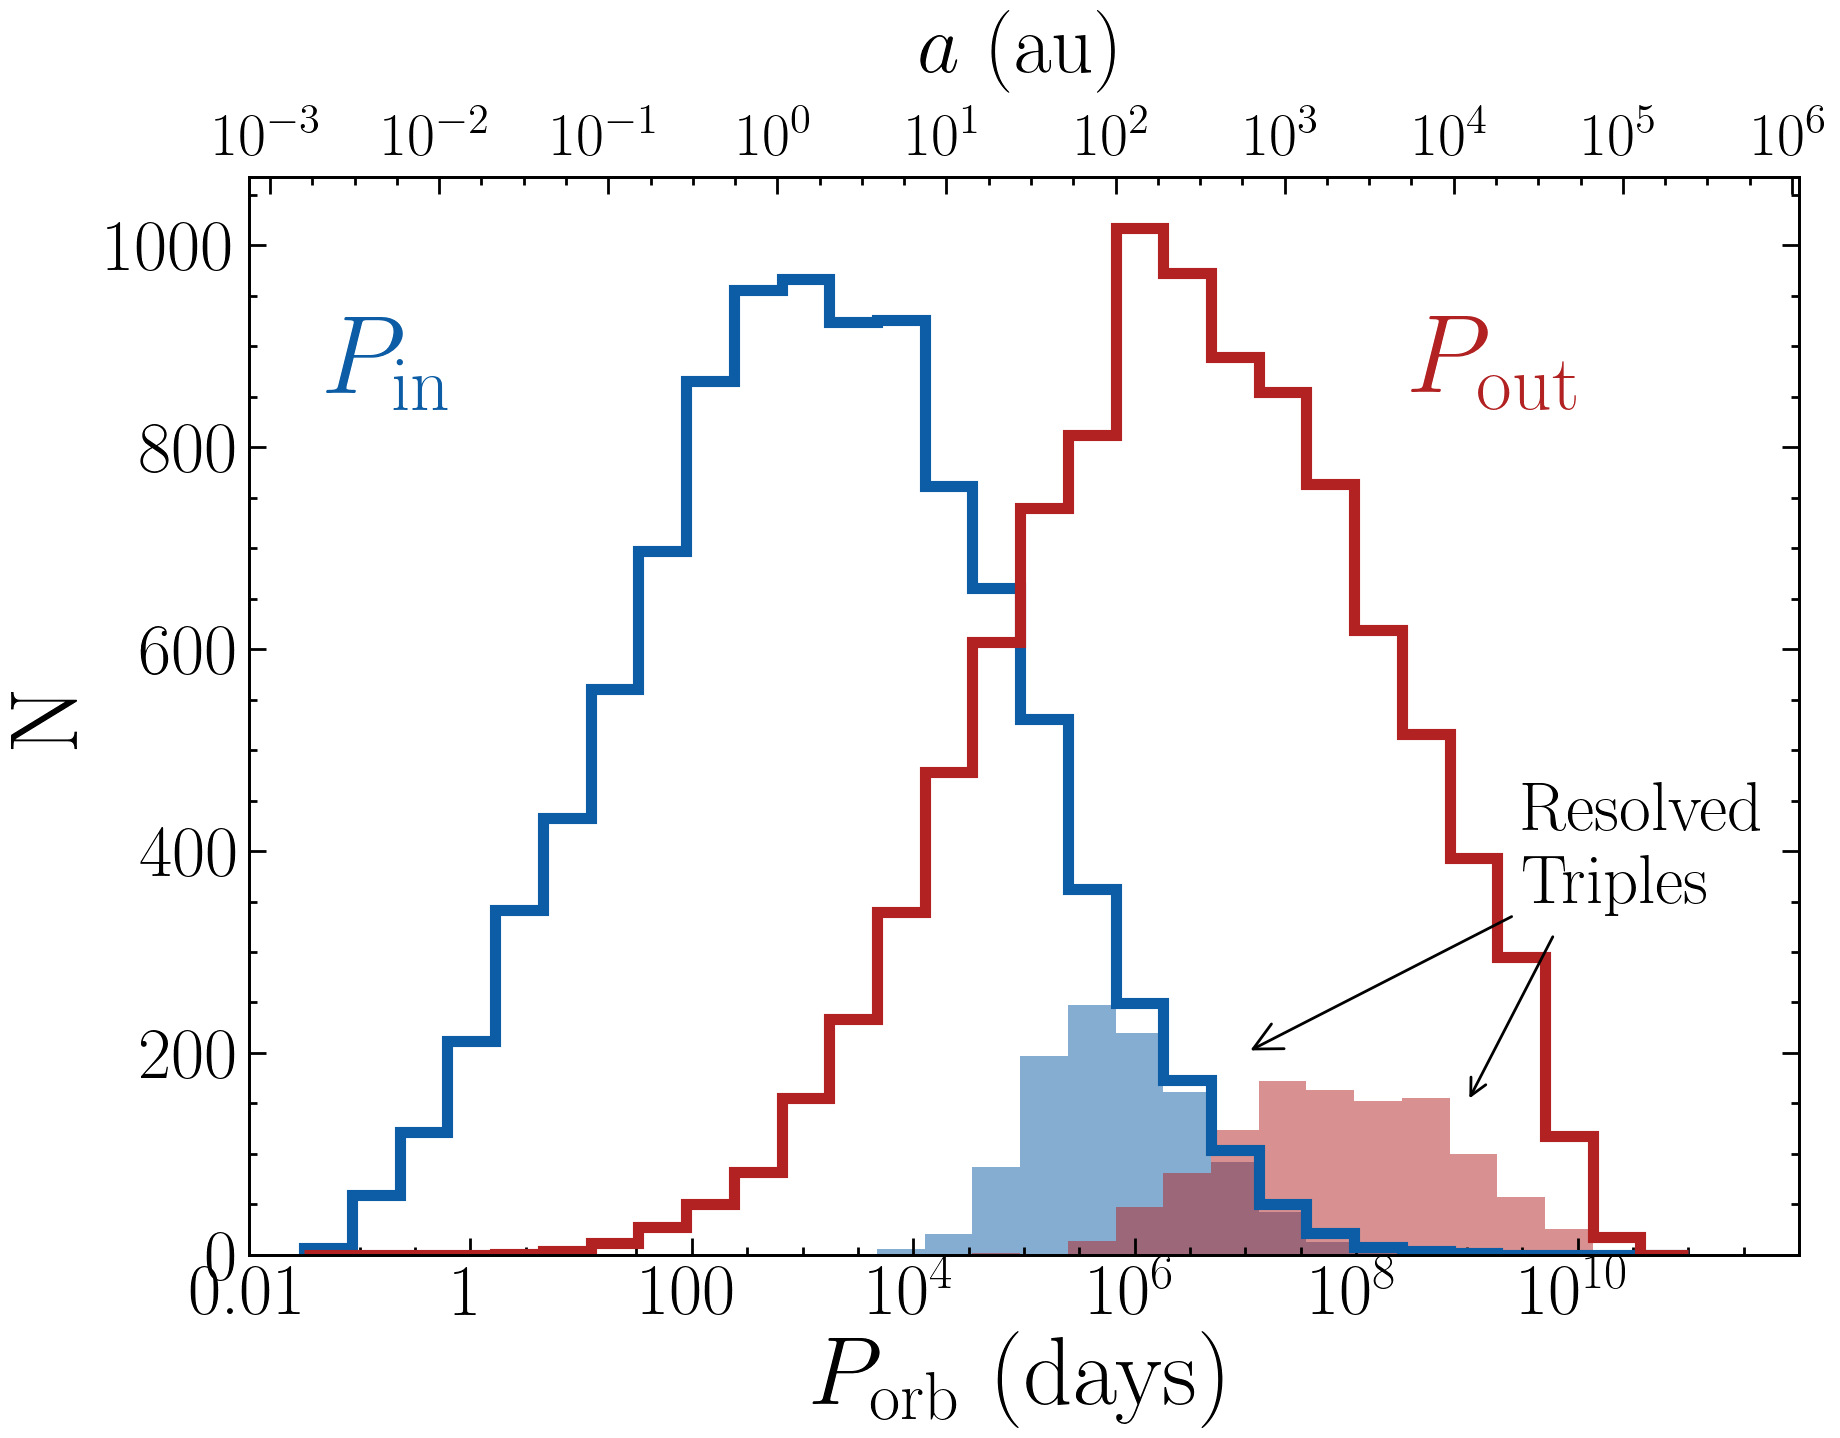

In [39]:
def Kepler_3rdLaw_SMA(m1,m2,SMA ): #M_sun and AU units, output in yr
    return np.power( ( (SMA**3)/(m1+m2) ) ,1./2.)


def plot_periods_resolved(P1,P2, P1_resolved,P2_resolved):
    fig, ax = plt.subplots(figsize=(10, 7))

    bins = np.linspace(-1.5, 11, 30)

    ax.hist(np.log10(P1*365.25), bins=bins,histtype='step',density=False, color='C0', linewidth=4, label='$s_1$ Model', rasterized=True)
    ax.hist(np.log10(P2*365.25), bins=bins,histtype='step',density=False, color='firebrick', linewidth=4, label='$s_2$ Model', rasterized=True)
    ax.hist(np.log10(P1_resolved*365.25), bins=bins, histtype='stepfilled', density=False, color='C0', linewidth=1, label='$s_1$ Model', alpha=0.5,edgecolor=None, rasterized=True)
    ax.hist(np.log10(P2_resolved*365.25), bins=bins, histtype='stepfilled', density=False, color='firebrick', linewidth=1, label='$s_2$ Model', alpha=0.5,edgecolor=None, rasterized=True)

    # Add arrows to indicate "Observed"
    ax.annotate("Resolved\nTriples", xy=(7, 200), xytext=(9.5, 350), 
                arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=25, color='black')
    ax.annotate("", xy=(9, 150), xytext=(9.8, 320), 
                arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=15, color='black')

    ax.set_xlabel(r"$P_{\rm orb}$ (days)", fontsize=35, labelpad=1)
    ax.set_ylabel(r"N", fontsize=35)

    ax.text(0.05, 0.8, r"$P_{\rm in}$", transform=ax.transAxes, fontsize=40,color='C0')
    ax.text(0.75, 0.8, r"$P_{\rm out}$", transform=ax.transAxes, fontsize=40,color='firebrick')

    log_P_ticks = [-2,0,2,4,6,8,10]
    ax.set_xticks(log_P_ticks, ['0.01','1','100'] + [f"$10^{{{int(P)}}}$" for P in log_P_ticks[3:]])  # Pretty labels


    log_a_ticks = np.arange(-3., 7.) 
    logP_ticks = np.log10(Kepler_3rdLaw_SMA(1, 0, 10**log_a_ticks)*365.25)

    # Add top axis
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())

    ax_top.set_xticks(logP_ticks, [f"$10^{{{int(a)}}}$" for a in log_a_ticks])
    ax_top.set_xlabel(r"$a$ (au)", fontsize=30, labelpad=15)
    ax_top.tick_params(axis='both', labelsize=22)
    ax.tick_params(axis='both', labelsize=26)

    ax.set_xlim(left=-2,right=12)
    # plt.savefig(fig_PATH + "DM91_triple_resolvedolved_N.pdf")

    plt.show()
    
    
    
P1, P2 = Kepler_3rdLaw_SMA(results_df_dm91comb.m1, results_df_dm91comb.m2, results_df_dm91comb.a1), Kepler_3rdLaw_SMA(results_df_dm91comb.m1+results_df_dm91comb.m2, results_df_dm91comb.m3, results_df_dm91comb.a2)
P1_resolved, P2_resolved = Kepler_3rdLaw_SMA(results_resolved.m1, results_resolved.m2, results_resolved.a1), Kepler_3rdLaw_SMA(results_resolved.m1+results_resolved.m2, results_resolved.m3, results_resolved.a2)

plot_periods_resolved(P1,P2, P1_resolved,P2_resolved)

# Example: Compare to Observations

In [ ]:
triples_catalog = pd.read_csv(data_PATH + "triples_catalog.csv")
triples100 = triples_catalog.query("1000/inner_star1_parallax<100 and triple_type == 'MSMS-MS'")

In [31]:
q_less06  = uniform_twin_vectorized(10000) #np.random.uniform(0.01,1,1)[0]

popt = (6.02879393,  1.5, -1.5, 10.,  0.3,  .8) #)(6.20246315,  1.49871649, -1.29309546, 10., 0.38535117,  0.81493948)
q_0608 = sample_from_doublebroken(10000, *popt)
popt = (3.60050256,  0.47014287, -2.00243637,  3.1597268,   0.275,       0.59633279) #( 7.43296433,  0.92133715, -1.4917705,   1.43329484, 0.24053111,  0.57500001)
q_1225 = sample_from_doublebroken(10000, *popt)
popt = (3.60050256,  0.0, -1.5,  -1.5,   0.3,       1) #( 7.43296433,  0.92133715, -1.4917705,   1.43329484, 0.24053111,  0.57500001)
q_25 = sample_from_doublebroken(100000, *popt)


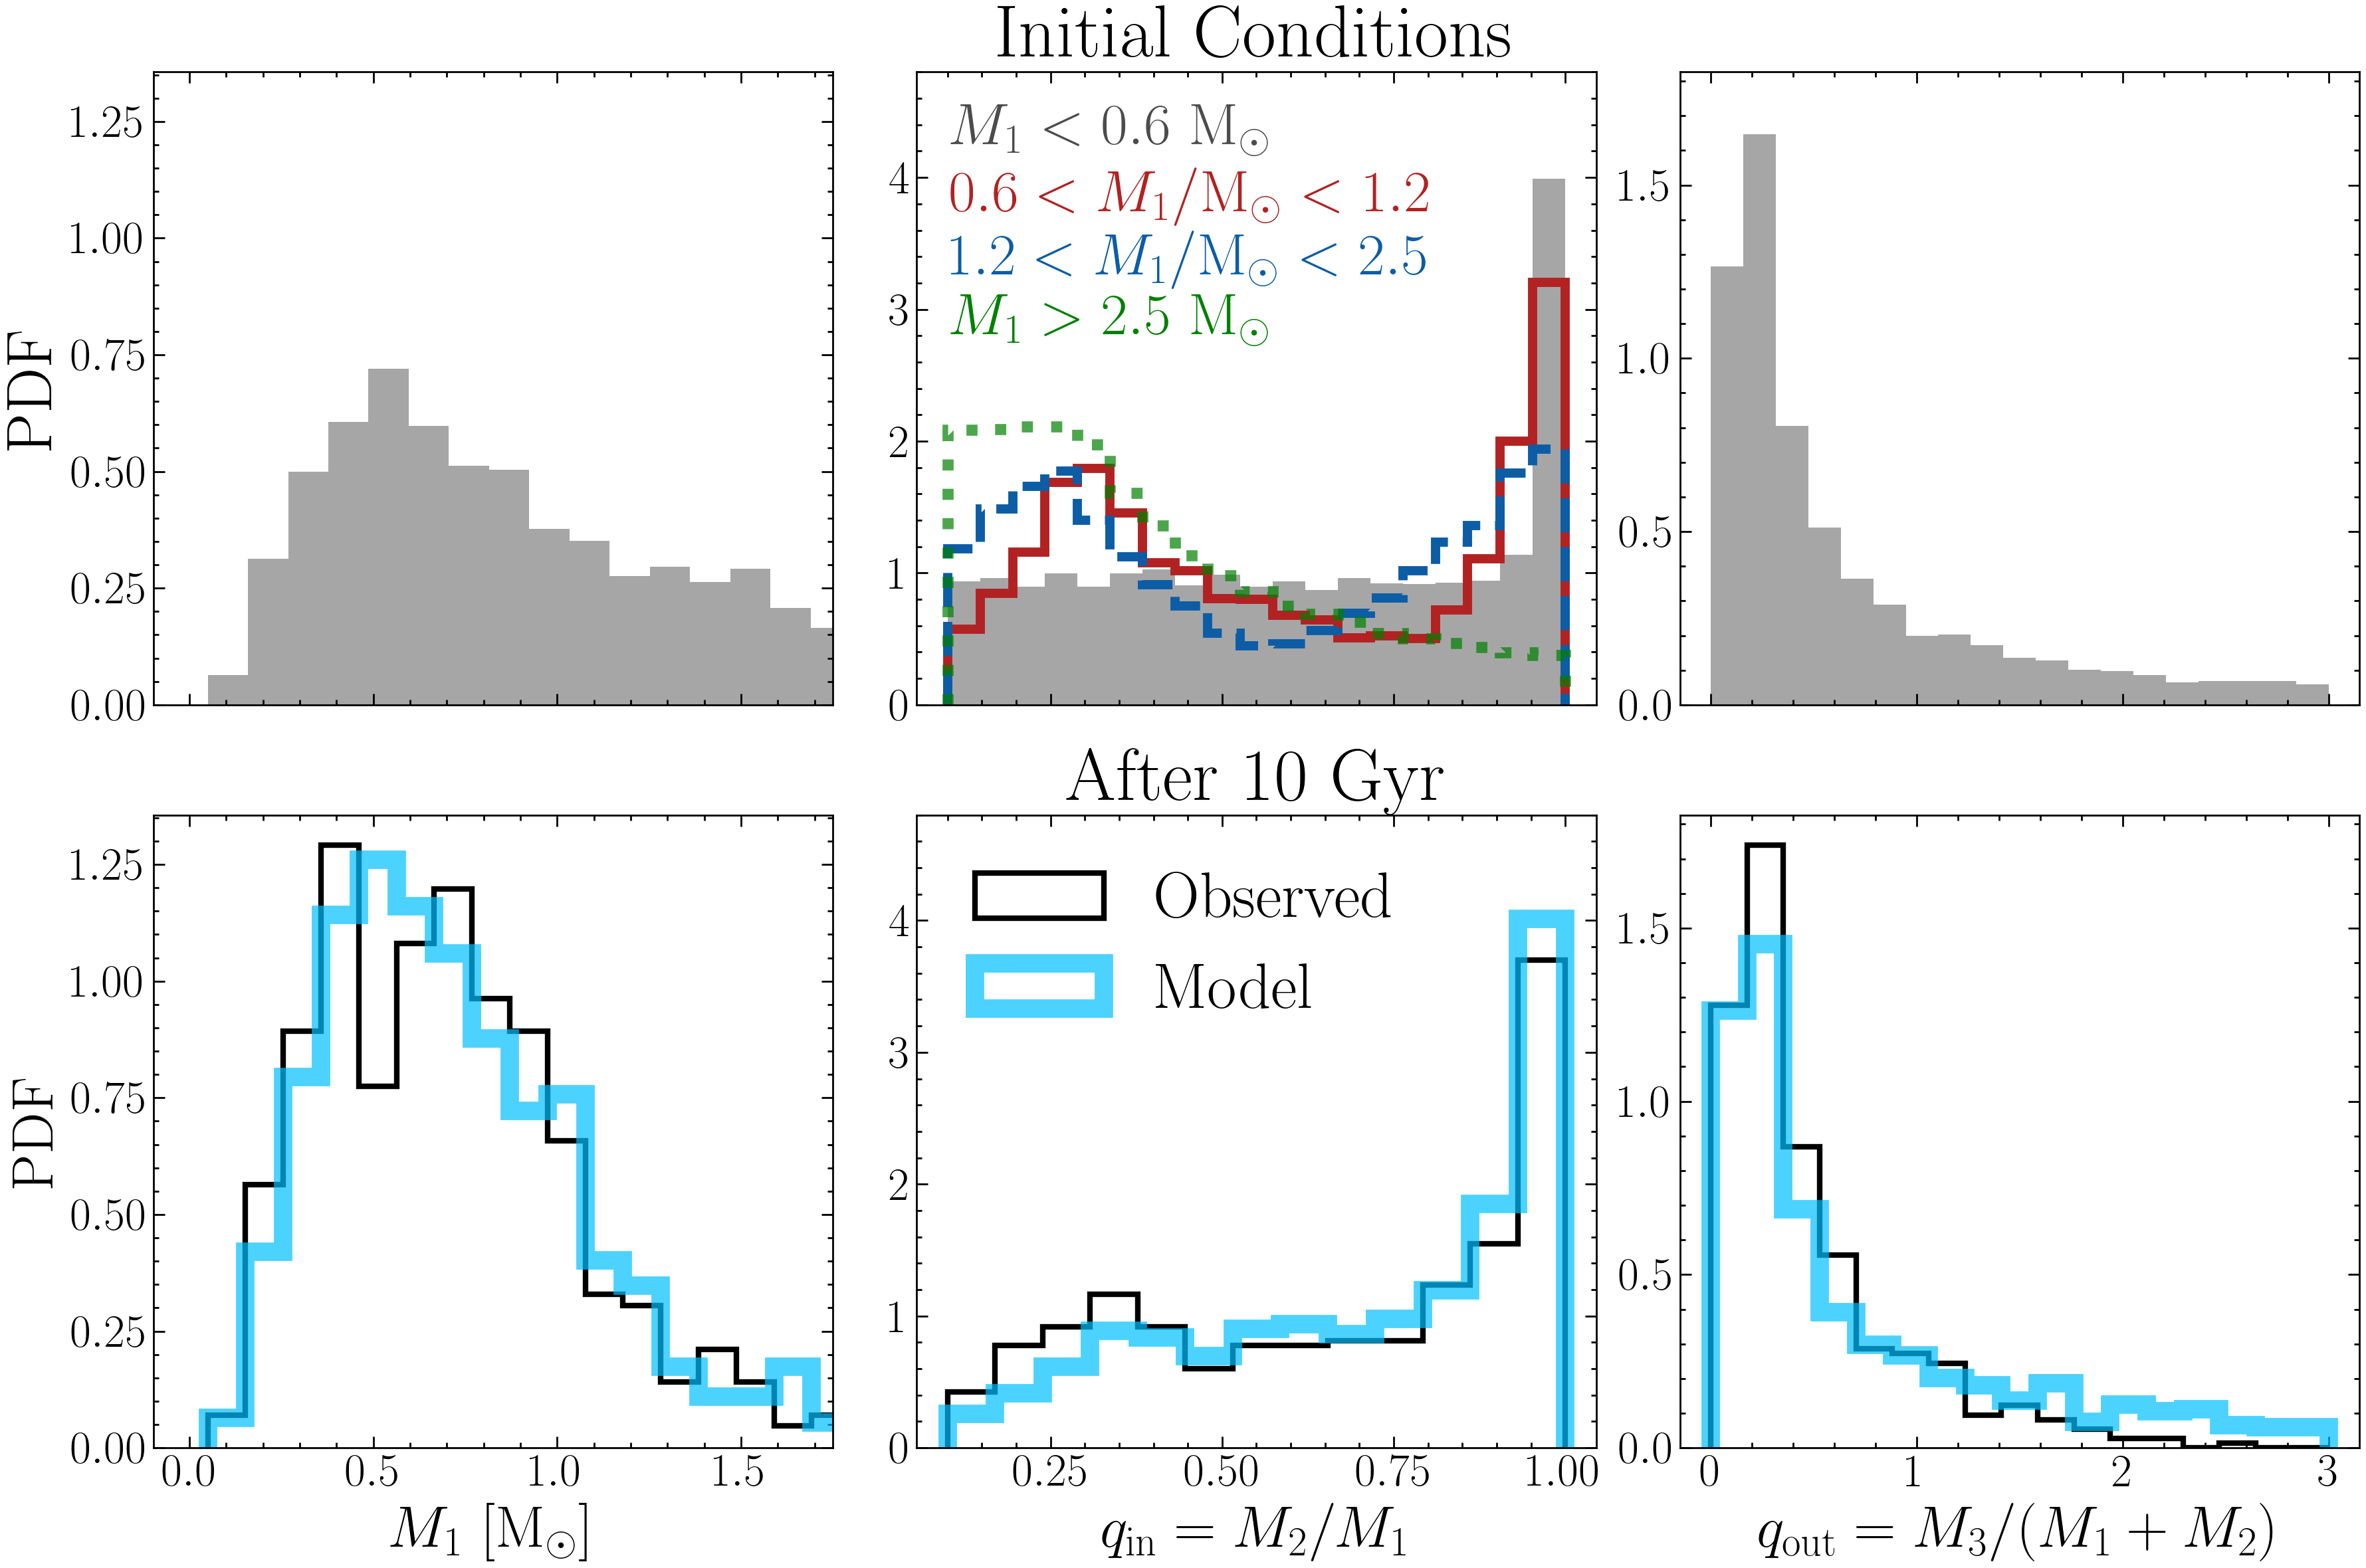

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex='col', sharey='col')#, gridspec_kw=dict(hspace=0.05))

# Top-left plot: m1 distribution (Initial Conditions)
bins = np.linspace(0.05, 3.0, 28)
axes[0, 0].hist(m1s_triples_i, bins=bins, histtype='stepfilled', color='k', linewidth=4, alpha=0.35, density=True)
axes[0, 0].set_ylabel("PDF", fontsize=35)
axes[0, 0].set_xlim(right=1.75)
axes[0, 1].set_title("Initial Conditions", fontsize=40)

# Top-middle plot: q_in distribution (Initial Conditions)
bins = np.linspace(0.1, 1., 20)
axes[0, 1].hist(q_less06, bins=bins, histtype='stepfilled', color='k', linewidth=4, alpha=0.35, density=True)
axes[0, 1].hist(q_0608, bins=bins, histtype='step', color='firebrick', linewidth=5, density=True)
axes[0, 1].hist(q_1225, bins=bins, histtype='step', color='C0', linewidth=5, density=True, linestyle='--')
axes[0, 1].hist(q_25, bins=bins, histtype='step', color='g', linewidth=6, density=True, linestyle=':',alpha=0.7)
axes[0, 1].text(0.05, 0.95, r"$M_1<0.6~{\rm M_\odot}$", transform=axes[0, 1].transAxes, fontsize=32, verticalalignment='top', color='k', alpha=0.7)
axes[0, 1].text(0.05, 0.85, r"$0.6<M_1/{\rm M_\odot}<1.2$", transform=axes[0, 1].transAxes, fontsize=32, verticalalignment='top', color='firebrick')
axes[0, 1].text(0.05, 0.75, r"$1.2<M_1/{\rm M_\odot}<2.5$", transform=axes[0, 1].transAxes, fontsize=32, verticalalignment='top', color='C0')
axes[0, 1].text(0.05, 0.65, r"$M_1 > 2.5~{\rm M_\odot}$", transform=axes[0, 1].transAxes, fontsize=32, verticalalignment='top', color='g')
axes[0, 1].set_ylim(top=4.8)
# Top-right plot: q_out distribution (Initial Conditions)
bins = np.linspace(0.0, 3., 20)
q_out = return_samples(N=10000, which=2)
axes[0, 2].hist(q_out, bins=bins, histtype='stepfilled', color='k', linewidth=4, alpha=0.35, density=True)

# Bottom-left plot: m1 distribution (After 10 Gyr)
axes[1, 1].set_title("After 10 Gyr", fontsize=40)

bins = np.linspace(0.05, 2., 20)
axes[1, 0].hist(triples100.mass1, bins=bins, density=True, histtype='step', linewidth=3, label='Observed', color='k')
axes[1, 0].hist(results_resolved.m1, bins=bins, density=True, histtype='step', linewidth=10, label='Model', color='deepskyblue', alpha=0.7)
axes[1, 0].set_xlabel(r"$M_1~{\rm [M_\odot]}$", fontsize=32)
axes[1, 0].set_ylabel("PDF", fontsize=32)

# Bottom-middle plot: q_in distribution (After 10 Gyr)
bins = np.linspace(0.1, 1., 14)
axes[1, 1].hist(triples100.mass2 / triples100.mass1, bins=bins, density=True, histtype='step', linewidth=3, label='Observed', color='k')
axes[1, 1].hist(results_resolved.m2 / results_resolved.m1, bins=bins, density=True, histtype='step', linewidth=10, label='Model', color='deepskyblue', alpha=0.7)
axes[1, 1].set_xlabel(r"$q_{\rm in} = M_2/M_1$", fontsize=32)
axes[1, 1].legend(fontsize=35)

# Bottom-right plot: q_out distribution (After 10 Gyr)
bins = np.linspace(0.0, 3., 18)
axes[1, 2].hist(triples100.mass3 / (triples100.mass1 + triples100.mass2), bins=bins, density=True, histtype='step', linewidth=3, label='Observed', color='k')
axes[1, 2].hist(results_resolved.m3 / (results_resolved.m1 + results_resolved.m2), bins=bins, density=True, histtype='step', linewidth=10, label='Filtered', color='deepskyblue', alpha=0.7)
axes[1, 2].set_xlabel(r"$q_{\rm out}= M_3/(M_1+M_2)$", fontsize=32)

for ax in axes.flat:
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
plt.tight_layout()
# plt.savefig(fig_PATH + "m_q_compare.pdf")
plt.show()


In [31]:
import os
from multiprocessing import Pool

columns = [
    "star_age", "star_mass", "star_mdot", "he_core_mass", "c_core_mass", "o_core_mass", 
    "log_L", "log_L_div_Ledd", "log_LH", "log_LHe", "log_LZ", "log_Teff", 
    "log_abs_Lgrav", "log_R", "log_g", "log_surf_z", "surf_avg_omega", 
    "surf_avg_v_rot", "surf_num_c12_div_num_o16", "v_wind_Km_per_s", 
    "surf_avg_omega_crit", "surf_avg_omega_div_omega_crit", "surf_avg_v_crit", 
    "surf_avg_v_div_v_crit", "surf_avg_Lrad_div_Ledd", "v_div_csound_surf", 
    "surface_h1", "surface_he3", "surface_he4", "surface_li7", "surface_be9", 
    "surface_b11", "surface_c12", "surface_c13", "surface_n14", "surface_o16", 
    "surface_f19", "surface_ne20", "surface_na23", "surface_mg24", "surface_si28", 
    "surface_s32", "surface_ca40", "surface_ti48", "surface_fe56", "log_center_T", 
    "log_center_Rho", "center_degeneracy", "center_omega", "center_gamma", 
    "mass_conv_core", "center_h1", "center_he4", "center_c12", "center_n14", 
    "center_o16", "center_ne20", "center_mg24", "center_si28", "pp", "cno", 
    "tri_alfa", "burn_c", "burn_n", "burn_o", "c12_c12", "delta_nu", "delta_Pg", 
    "nu_max", "acoustic_cutoff", "max_conv_vel_div_csound", "max_gradT_div_grada", 
    "gradT_excess_alpha", "min_Pgas_div_P", "max_L_rad_div_Ledd", "e_thermal", "phase"
]


In [83]:
mass_age_MS = pd.read_csv("./Data/MS_mass_age.csv")
masses, ages = mass_age_MS['Mass'].values, mass_age_MS['Age'].values
mass_age_interp = interp1d(masses, ages, kind='linear', fill_value="extrapolate")
